## imports

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join as pjoin
from tqdm import tqdm
import os

In [1]:
import meshpy.triangle as tri
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import find_contours

## creating nodes and mesh

In [88]:
def distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def repulsive_force(p1, p2):
    dist = distance(p1, p2)
    if dist == 0:
        return 0
    return 1 / dist

def simulate_npbs(points, iterations=1000, step_size=0.01):
    new_points = points.copy()
    for _ in tqdm(range(iterations)):
        for i in range(len(points)):
            force = np.zeros(2)
            for j in range(len(points)):
                if i != j:
                    force += repulsive_force(points[i], points[j]) * (points[i] - points[j])
            new_points[i] += step_size * force
    return new_points

In [89]:
# Define the domain size and number of nodes
domain_size = [10, 10]
num_nodes = 100

# Generate random initial node positions within the domain
nodes = np.random.rand(num_nodes, 2) * domain_size

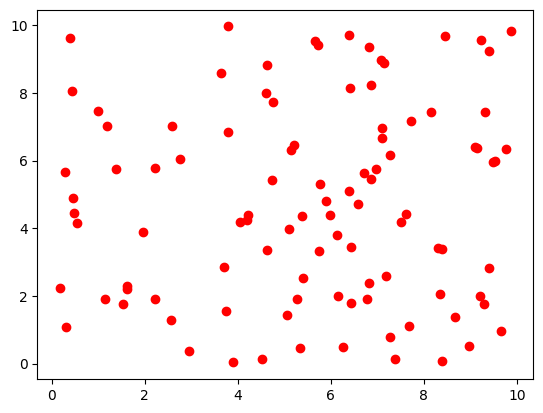

In [90]:
plt.plot(nodes[:,0],nodes[:,1], 'ro')
plt.show()

In [91]:
# Perform NPBS simulation to optimize node positions
optimized_nodes = simulate_npbs(nodes)

100%|██████████| 1000/1000 [00:55<00:00, 17.99it/s]


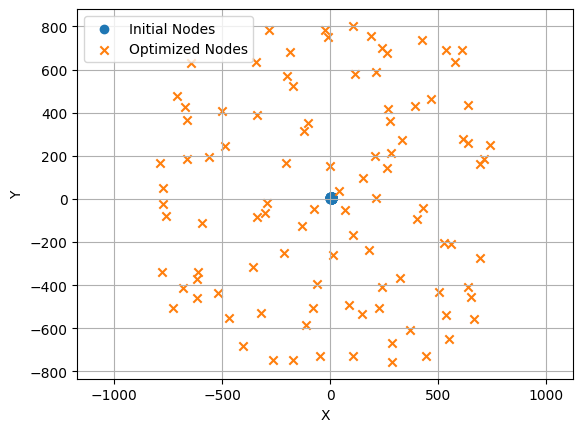

In [92]:
# Visualize the results
plt.scatter(nodes[:, 0], nodes[:, 1], label='Initial Nodes')
plt.scatter(optimized_nodes[:, 0], optimized_nodes[:, 1], label='Optimized Nodes', marker='x')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

## our object

In [5]:
# Загрузка изображения силуэта объекта
image = io.imread(pjoin('images','frame_0_mask.png'))

# Преобразование изображения в бинарное
binary_image = image[:, :, 0] > 0

### simple mesh

In [95]:
h, w = image.shape[:2]

In [97]:
x_mash_step, y_mash_step = 25, 25

In [98]:
y_mash = np.arange(0, h+1, y_mash_step)
x_mash = np.arange(0, w+1, x_mash_step)

In [102]:
_s = np.load(pjoin('actual pos','all_pos_vals.npy'))

In [ ]:
np

In [106]:
_s[0] # (x, y)

array([[9.93198395e-01, 9.60201454e+00],
       [1.01012421e+00, 2.59780769e+01],
       [1.01922035e+00, 4.20226517e+01],
       ...,
       [2.15700000e+03, 7.61000000e+02],
       [2.15700000e+03, 7.77000000e+02],
       [2.15700000e+03, 7.93000000e+02]])

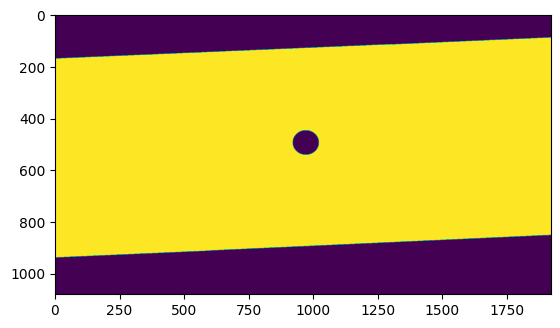

In [9]:
plt.imshow(binary_image)
plt.show()

In [23]:
pad_size = 10

[]

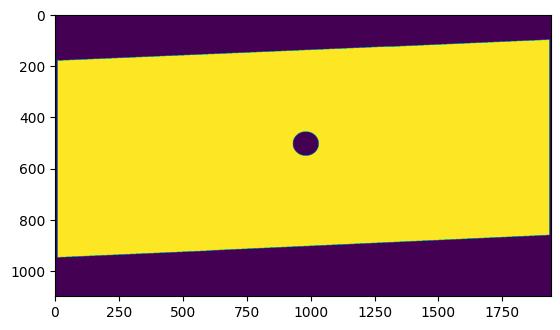

In [24]:
plt.imshow(np.pad(binary_image,pad_size))
plt.plot()

In [25]:
# Нахождение контура объекта
contours = find_contours(np.pad(binary_image,pad_size), 0.5)

In [28]:
frame_0 = cv2.imread(pjoin('images','frame_0.png'))

In [34]:
np.pad(frame_0, ((pad_size, pad_size), (pad_size, pad_size), (0,0))).shape

(1100, 1940, 3)

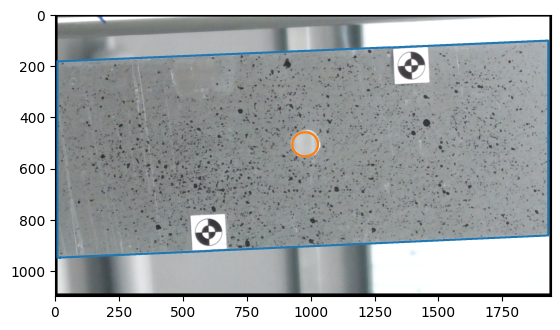

In [36]:
plt.imshow(np.pad(frame_0, ((pad_size, pad_size), (pad_size, pad_size), (0,0))))
for c in contours:
    plt.plot(c[:,1],c[:,0])
plt.show()

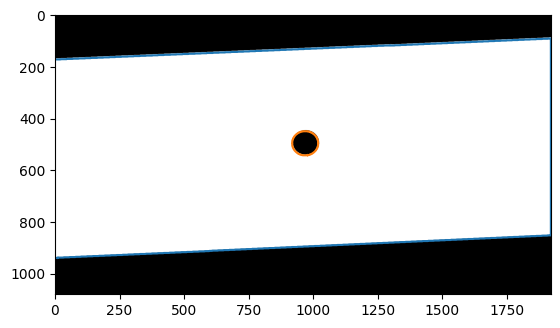

In [37]:
plt.imshow(image)
for c in contours:
    plt.plot(c[:,1]-pad_size,c[:,0]-pad_size)
plt.show()

In [38]:
moved_contours = contours.copy()

In [39]:
for i, c in enumerate(moved_contours):
    contours[i] = c - pad_size

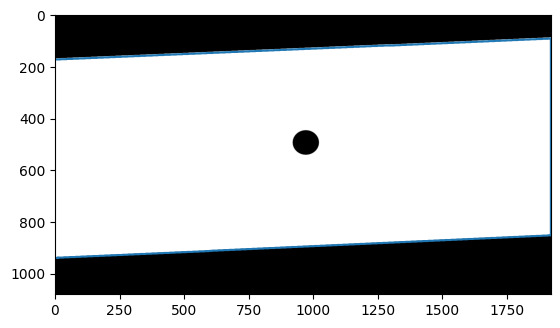

In [46]:
plt.imshow(image)
# for c in contours:
plt.plot(contours[0][:,1],contours[0][:,0])
plt.show()

In [51]:
# Выделение контура объекта
object_contour = contours[0]

# Создание неравномерной сетки с адаптивной плотностью узлов на границе объекта
mesh_info = tri.MeshInfo()
mesh_info.set_points(object_contour)
mesh_info.set_holes(contours[1])  # Если есть отверстия внутри объекта, их также можно указать
mesh = tri.build(mesh_info, refinement_func='mean_ratio')

In [53]:
print("Mesh Points:")
for i, p in enumerate(mesh.points):
    print(i, p)
print("Point numbers in tetrahedra:")
for i, t in enumerate(mesh.elements):
    print(i, t)
# mesh.write_vtk("test.vtk")

Mesh Points:
Point numbers in tetrahedra:


In [56]:
contours[0]

array([[938.5,  10. ],
       [938.5,   9. ],
       [938.5,   8. ],
       ...,
       [937.5,  11. ],
       [938. ,  10.5],
       [938.5,  10. ]])

In [57]:
# Create an empty list to store the vertices
vertices = []

# Convert the contour coordinates to vertices
for contour in contours:
    for point in contour:
        vertices.append([point[0], point[1]])

# Create a mesh using meshpy
mesh_info = tri.MeshInfo()
mesh_info.set_points(vertices)
mesh = tri.build(mesh_info)

# Access the mesh vertices and triangles
mesh_vertices = mesh.points
mesh_triangles = mesh.elements

# Perform further operations with the mesh...

3

In [58]:
# Visualize the mesh
plt.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.elements)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

RuntimeError: Unable to cast Python instance to C++ type (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)

RuntimeError: Unable to cast Python instance to C++ type (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)

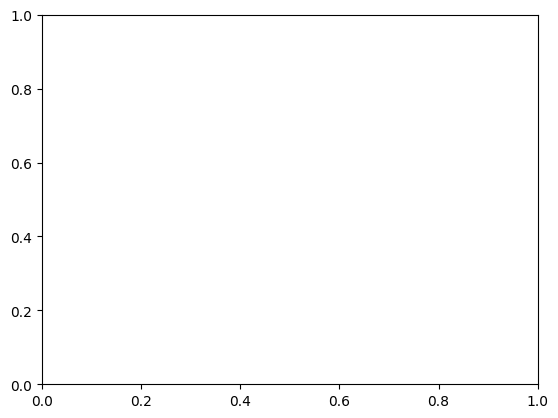

In [41]:
# Визуализация сетки
fig, ax = plt.subplots()
ax.tripcolor(mesh.points[:, 0], mesh.points[:, 1], mesh.elements,
             facecolors='none', edgecolors='black')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Неравномерная сетка объекта')
plt.show()

In [8]:
mesh.elements